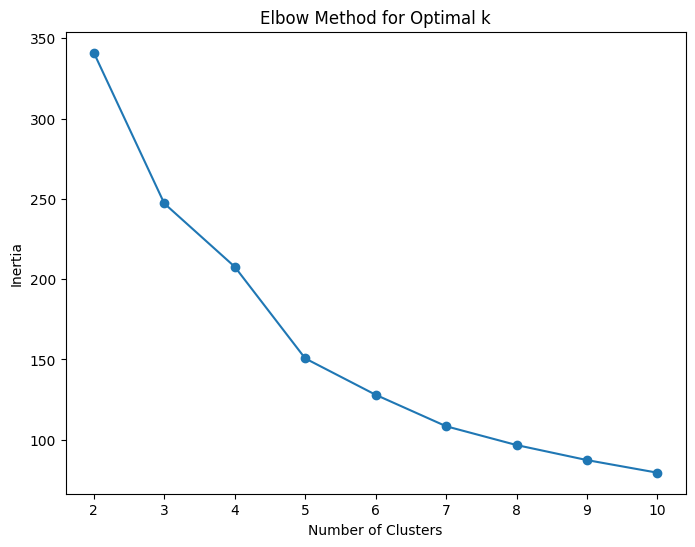

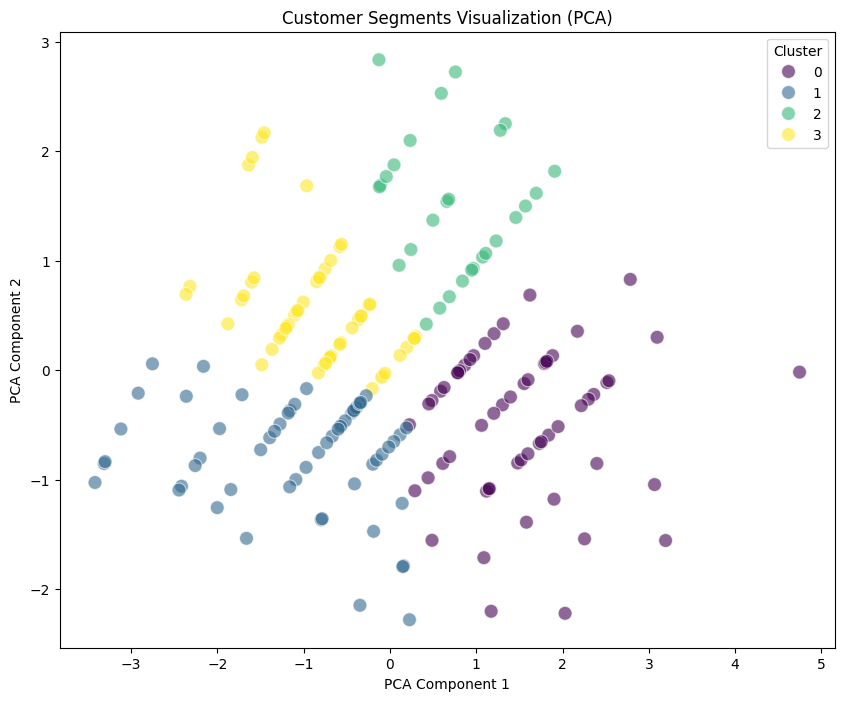

Davies-Bouldin Index: 1.060424039992303
Silhouette Score: 0.3135106549790538
Cluster Centers (in original scale):
   total_spent  total_transactions  avg_transaction_value
0  5521.543966            7.517241             741.147332
1  2103.758333            4.583333             435.310875
2  4317.132143            4.142857            1056.828643
3  2313.977547            3.264151             719.472764

Cluster Insights:
   Cluster  Total Customers  Avg Total Spent  Avg Transactions  \
0        0               58      5521.543966          7.517241   
1        1               60      2103.758333          4.583333   
2        2               28      4317.132143          4.142857   
3        3               53      2313.977547          3.264151   

   Avg Transaction Value  
0             741.147332  
1             435.310875  
2            1056.828643  
3             719.472764  


In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# Load the data
customers = pd.read_csv('/Users/anshporwal/Desktop/eCommerce Analysis/Customers.csv')
transactions = pd.read_csv('/Users/anshporwal/Desktop/eCommerce Analysis/Transactions.csv')

# Data Preprocessing
# Merging Customers and Transactions on CustomerID to get complete transaction data for each customer
data = pd.merge(transactions, customers, on='CustomerID', how='inner')

# Aggregating data at Customer level
customer_data = data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

# Handling missing data if any (optional)
customer_data.fillna(0, inplace=True)

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[['total_spent', 'total_transactions', 'avg_transaction_value']])

# Finding the optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Based on the elbow plot, choosing the optimal number of clusters (let's assume it's 4)
optimal_clusters = 4

# Applying KMeans Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Adding cluster centers to the DataFrame for reference
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['total_spent', 'total_transactions', 'avg_transaction_value'])
centroids = scaler.inverse_transform(centroids)  # Inverse scaling to get original scale

# Visualizing the clusters using PCA for 2D representation
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_data['Cluster'], palette='viridis', s=100, alpha=0.6)
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Calculate the Davies-Bouldin Index (DB Index) for evaluation
db_index = davies_bouldin_score(scaled_data, customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Calculate Silhouette Score
silhouette_avg = silhouette_score(scaled_data, customer_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# Output the cluster centers
print("Cluster Centers (in original scale):")
print(pd.DataFrame(centroids, columns=['total_spent', 'total_transactions', 'avg_transaction_value']))

# Insight generation based on clusters
cluster_insights = []
for cluster in range(optimal_clusters):
    cluster_data = customer_data[customer_data['Cluster'] == cluster]
    insight = {
        'Cluster': cluster,
        'Total Customers': len(cluster_data),
        'Avg Total Spent': cluster_data['total_spent'].mean(),
        'Avg Transactions': cluster_data['total_transactions'].mean(),
        'Avg Transaction Value': cluster_data['avg_transaction_value'].mean()
    }
    cluster_insights.append(insight)

insights_df = pd.DataFrame(cluster_insights)
print("\nCluster Insights:")
print(insights_df)

# Saving the clustered data to a CSV for further analysis
customer_data.to_csv('/Users/anshporwal/Desktop/eCommerce Analysis/Ansh_Porwal_Clustering.csv', index=False)

